In [1]:
import os 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import geopandas as gp
import pandas as pd
import sklearn 
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import xgboost as xgb
def cl2idx(inputarr, dict_label):
    y_label = np.zeros((inputarr.shape[0] ))
    for i in range(inputarr.shape[0]):
            y_label[i] = dict_label[inputarr[i, 0]]
    return y_label



In [2]:

joind = gp.read_file("../input/reclassified-ml/reclasified_ml/reclassified_ml.shp")
 

df1 = pd.DataFrame(joind.drop(columns='geometry'))
df1 = df1.replace([np.inf, -np.inf], np.nan).dropna()

df1.columns 

Index(['density_SB', 'density_SD', 'Dif_bri_BD', 'EF_SB', 'EF_SD',
       'GLCM_Co_gr', 'GLCM_Co_ni', 'GLCM_Co_re', 'GLCM_Co_br', 'GLCM_Ho_br',
       'GLCM_Ho_gr', 'GLCM_Ho_ni', 'GLCM_Ho_re', 'LW_SB', 'LW_SD', 'max_SI_SS',
       'max_SI_SSM', 'max_SI_sub', 'mean_abs_d', 'mean_aspec', 'mean_brigh',
       'mean_green', 'mean_ndvi', 'mean_nir', 'mean_red', 'mn_area_SB',
       'mn_area_SD', 'mn_bri_BmD', 'mn_bri_DmB', 'mn_bri_SB', 'mn_bri_SD',
       'mn_SI_SB', 'mn_SI_SD', 'num_sub_ha', 'obj_ha_SS', 'obj_ha_SSM',
       'SI_SB_SS', 'SI_SB_SSM', 'SI_SD_SS', 'SI_SD_SSM', 'std_brigh',
       'std_green', 'std_ndvi', 'std_nir', 'std_red', 'tot_BL_SB', 'tot_BL_SD',
       'Shape_Leng', 'Shape_Area', 'index_righ', 'GEOCODE2', 'OBJECTID',
       'OMS_GEOCOD', 'JAAR', 'Shape_Le_1', 'Shape_Ar_1', 'Legcod', 'group_M'],
      dtype='object')

In [3]:
Pcl = df1.loc[df1['group_M'].isin(['P1a1','P1a2', 'P2c','P2b'])]

In [4]:
print(f'total {len(df1)}, P_classes: {len(Pcl)}')

total 170981, P_classes: 66520


In [5]:
train = Pcl.groupby('group_M').sample(frac=.8).index
test = Pcl[~Pcl.index.isin(train)].index
len(train)+len(test)

66520

In [6]:
df_covar = Pcl.filter(regex='density|Dif_|EF|GLCM|LW|max_SI|mean_|mn_|num|obj|SI_|std|tot')
df_covar[df_covar>1e5] =0 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [7]:
 
X_train = df_covar.loc [train ]
X_test  = df_covar.loc  [test ]
Y_train  =Pcl.filter(regex='group_M').loc[train ]
Y_test  =Pcl.filter(regex='group_M').loc[test ]
Y_train= Y_train.values
Y_test = Y_test.values
 


 #string.ascii_lowercase

"""xgboost softmax regression"""


'xgboost softmax regression'

In [8]:
label_all =  Pcl.group_M.unique()
i = 0
idx2class = {}
class2idx = {}
for tp in label_all:
    idx2class[i] = tp
    class2idx[tp] = i 
    i+= 1


In [9]:
 
Y_trainnum = cl2idx(Y_train, class2idx)
Y_testnum = cl2idx(Y_test, class2idx)
 
 

In [10]:
Y_train.shape

(53217, 1)

In [11]:
np.unique(Y_trainnum)

array([0., 1., 2., 3.])

In [12]:

dtrain = xgb.DMatrix(X_train, label=Y_trainnum)
dtest = xgb.DMatrix(X_test, label=Y_testnum)
params = {'max_depth': 6, 'eta': 0.002, 'silent': 1, 'n_estimators' : 1500,
          'objective': 'multi:softprob', 'num_class': len(np.unique(Y_trainnum)), 'eval_metric':['merror', 'mlogloss', 'auc' ] }
# Fit

# Evalute

 
 

In [13]:
model = xgb.train(params, dtrain, 100)

[15:37:11] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [14]:
yhat = model.predict(dtest)
yhat_labels = np.argmax(yhat, axis=1)

In [15]:
accuracy = accuracy_score(Y_testnum, yhat_labels)
print("precision:  tp / (tp + fp)")
print(precision_score(Y_testnum, yhat_labels, average = None))

print("recall:  tp / (tp + fn)") 
print(recall_score(Y_testnum, yhat_labels, average = None))

recall=recall_score(Y_testnum, yhat_labels, average = 'weighted')
precision=precision_score(Y_testnum, yhat_labels, average = "weighted")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%% " % (precision *100))
print("Recall: %.2f%% " % (recall * 100))
print(class2idx)




precision:  tp / (tp + fp)
[0.45398482 0.53096134 0.54623656 0.63786957]
recall:  tp / (tp + fn)
[0.50944903 0.56933236 0.26746227 0.76605389]
Accuracy: 54.65%
Precision: 54.44% 
Recall: 54.65% 
{'P1a1': 0, 'P1a2': 1, 'P2c': 2, 'P2b': 3}


In [16]:
Y_testnum =  Y_testnum.astype(int)

In [17]:
cm  = confusion_matrix(Y_testnum, yhat_labels)
cm

array([[1914,  929,  287,  627],
       [ 815, 1552,  135,  224],
       [ 886,  325,  762,  876],
       [ 601,  117,  211, 3042]])

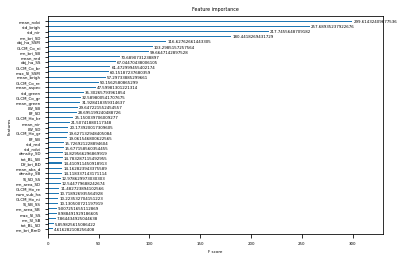

In [18]:
plt.rcParams.update({'font.size': 4})
xgb.plot_importance(model, grid=False, importance_type='gain', title='Feature importance')

fname = "obia importance"
plt.savefig(fname, dpi=1200)

 

In [19]:
'''
plt.rcParams.update({'font.size': 4})
xgb.plot_tree(model, num_trees=2)
fname = "xgb_tree2"
plt.savefig(fname, dpi=1200)

plt.rcParams.update({'font.size': 4})
xgb.plot_tree(model, num_trees=1000)
fname = "xgb_tree1000"
plt.savefig(fname, dpi=1200)
'''


'\nplt.rcParams.update({\'font.size\': 4})\nxgb.plot_tree(model, num_trees=2)\nfname = "xgb_tree2"\nplt.savefig(fname, dpi=1200)\n\nplt.rcParams.update({\'font.size\': 4})\nxgb.plot_tree(model, num_trees=1000)\nfname = "xgb_tree1000"\nplt.savefig(fname, dpi=1200)\n'

In [20]:
#xgb.to_graphviz(model, num_trees=2)

In [21]:
classes = ['P1a1', 'P1a2', 'P2c', 'P2b']

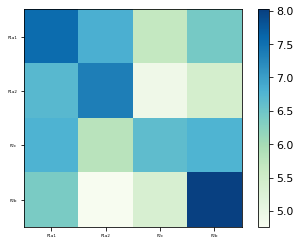

In [22]:
# column is predicted
 
fig, ax = plt.subplots(1,1)
plt.rcParams.update({'font.size': 11})
plt.imshow(np.log(cm), cmap=plt.get_cmap("GnBu"))
ax.set_xticks([0,1,2,3])
ax.set_yticks([0,1,2,3])
ax.set_xticklabels(classes )
ax.set_yticklabels(classes )

plt.colorbar()

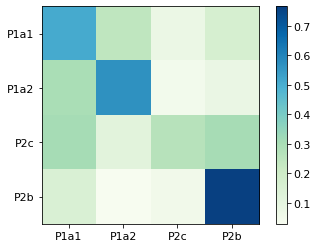

In [23]:
fig, ax = plt.subplots(1,1)
cm  = confusion_matrix(Y_testnum, yhat_labels,normalize='true')
plt.imshow(cm, cmap=plt.get_cmap("GnBu"))
ax.set_xticks([0,1,2,3])
ax.set_yticks([0,1,2,3])
ax.set_xticklabels(classes )
ax.set_yticklabels(classes )

plt.colorbar() 
# TP/ all True

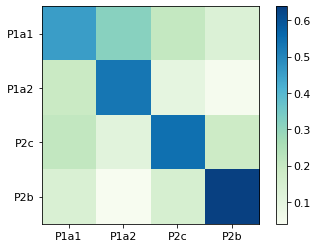

In [24]:
fig, ax = plt.subplots(1,1)
cm  = confusion_matrix(Y_testnum, yhat_labels,normalize='pred')
plt.imshow(cm, cmap=plt.get_cmap("GnBu"))
ax.set_xticks([0,1,2,3])
ax.set_yticks([0,1,2,3])
ax.set_xticklabels(classes )
ax.set_yticklabels(classes )

plt.colorbar() 
# TP/ (all predicted T), most of the times, the predictions. 

In [25]:
testgeo = pd.DataFrame(joind["geometry"].iloc[test])
testgeo["test_truth"] =  Y_test
testgeo["predicted"] =  yhat_labels
testgeo["truth_num"] = Y_testnum
testgeo = testgeo.set_geometry('geometry')

In [26]:
'''
testgeo.to_file("testP.shp")
'''

'\ntestgeo.to_file("testP.shp")\n'

In [27]:


def merror(predt: np.ndarray, dtrain: xgb.DMatrix):
    y = dtrain.get_label()
    # Like custom objective, the predt is untransformed leaf weight
    assert predt.shape == (kRows, kClasses)
    out = np.zeros(kRows)
    for r in range(predt.shape[0]):
        i = np.argmax(predt[r])
        out[r] = i

    assert y.shape == out.shape

    errors = np.zeros(kRows)
    errors[y != out] = 1.0
    return 'PyMError', np.sum(errors) / kRows


